In [1]:
import numpy as np
import copy
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy.signal import lfilter
import soundfile as sf

# nahrání tónů, výběr odpovídající sekundy
toneoff_fs, toneoff = wavfile.read('./../audio/maskoff_tone.wav')
toneoff3 = toneoff
toneoff2 = toneoff[21760:37760]
toneon_fs, toneon = wavfile.read('./../audio/maskon_tone.wav')
toneon3 = toneon
toneon2 = toneon[21760:37760]
sentenceoff_fs, sentenceoff = wavfile.read('./../audio/maskoff_sentence.wav')
sentenceoff = sentenceoff[1700:46700]
sentenceon_fs, sentenceon = wavfile.read('./../audio/maskon_sentence.wav')
sentenceon = sentenceon[:45000]
t = np.arange(toneoff.size) / toneoff_fs

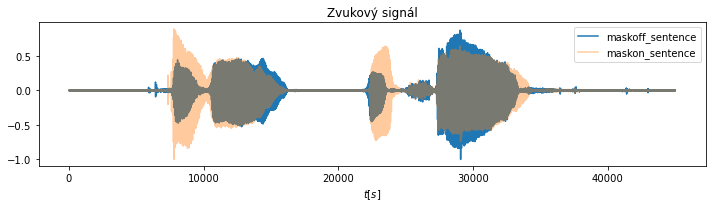

In [2]:
# zobrazení vět, normalizace a ustřednění
sentenceoff = sentenceoff - np.mean(sentenceoff)
sentenceoff = sentenceoff / np.abs(sentenceoff).max()
sf.write('./../audio/maskoff_sentence_norm.wav', sentenceoff, 16000)

sentenceon = sentenceon - np.mean(sentenceon)
sentenceon = sentenceon / np.abs(sentenceon).max()
sf.write('./../audio/maskon_sentence_norm.wav', sentenceon, 16000)

plt.figure(figsize=(10,3))
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál')
plt.plot(sentenceoff, label="maskoff_sentence")
plt.plot(sentenceon, label="maskon_sentence", alpha=0.4)
plt.legend()
plt.tight_layout()

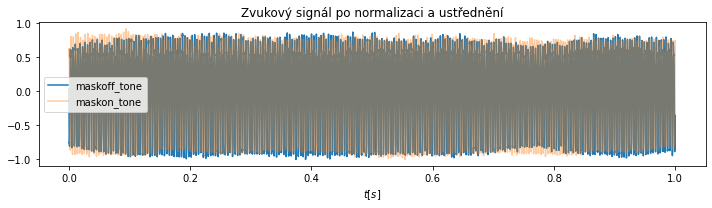

In [3]:
# normalizace a ustřednění
toneoff2 = toneoff2 - np.mean(toneoff2)
toneoff2 = toneoff2 / np.abs(toneoff2).max()

toneon2 = toneon2 - np.mean(toneon2)
toneon2 = toneon2 / np.abs(toneon2).max()

toneoff3 = toneoff3 - np.mean(toneoff3)
toneoff3 = toneoff3 / np.abs(toneoff3).max()

toneon3 = toneon3 - np.mean(toneon3)
toneon3 = toneon3 / np.abs(toneon3).max()

t2 = np.arange(toneoff2.size) / toneoff_fs
plt.figure(figsize=(10,3))
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál po normalizaci a ustřednění')
plt.plot(t2, toneoff2, label="maskoff_tone")
plt.plot(t2, toneon2, label="maskon_tone", alpha=0.4)
plt.legend()
plt.tight_layout()

In [4]:
# rozdělení na rámce - toneoff
frames_toneoff = []
begin = 0
end = 320
for i in range(99):
    val = toneoff2[begin:end]
    frames_toneoff.append(val)
    begin += 160
    end += 160
    
frames_toneoff_2 = copy.deepcopy(frames_toneoff)

In [5]:
# rozdělení na rámce - toneon
frames_toneon = []
begin = 0
end = 320
for i in range(99):
    val = toneon2[begin:end]
    frames_toneon.append(val)
    begin += 160
    end += 160
    
frames_toneon_2 = copy.deepcopy(frames_toneon)

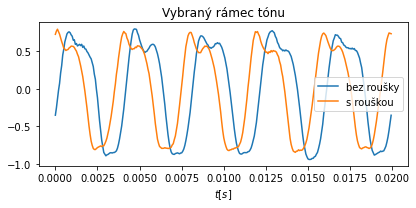

In [6]:
# příklad jednoho z rámců
t3 = np.arange(320) / 16000
plt.figure(figsize=(6,3))
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Vybraný rámec tónu')
plt.plot(t3, frames_toneoff[98], label="bez roušky")
plt.plot(t3, frames_toneon[98], label="s rouškou")
plt.legend()
plt.tight_layout()

In [7]:
# centrální klipování bez roušky
for frame in range(99):
    max1 = abs(max(frames_toneoff_2[frame], key=abs))
    for i in range(len(frames_toneoff_2[frame])):
        if frames_toneoff_2[frame][i] > max1/100*70:
            frames_toneoff_2[frame][i] = 1
        elif frames_toneoff_2[frame][i] < -max1/100*70:
            frames_toneoff_2[frame][i] = -1
        else:
            frames_toneoff_2[frame][i] = 0

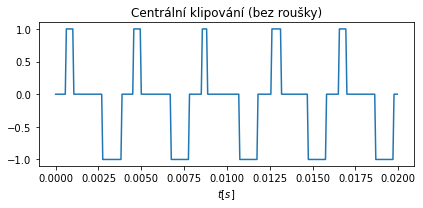

In [8]:
plt.figure(figsize=(6,3))
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Centrální klipování (bez roušky)')
plt.plot(t3, frames_toneoff_2[98])
plt.tight_layout()

In [9]:
# centrální klipování s rouškou
for frame in range(99):
    max2 = abs(max(frames_toneon_2[frame], key=abs))
    for i in range(len(frames_toneon_2[frame])):
        if frames_toneon_2[frame][i] > max2/100*70:
            frames_toneon_2[frame][i] = 1
        elif frames_toneon_2[frame][i] < -max2/100*70:
            frames_toneon_2[frame][i] = -1
        else:
            frames_toneon_2[frame][i] = 0

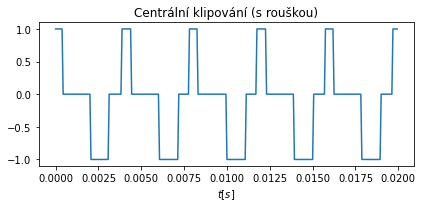

In [10]:
plt.figure(figsize=(6,3))
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Centrální klipování (s rouškou)')
plt.plot(t3, frames_toneon_2[98])
plt.tight_layout()

In [11]:
# autokorelace bez roušky
f0_1 = []
l1 = []
for frame in range(99):
    Rlist = []
    N = len(frames_toneoff_2[frame])
    k = 0
    for k in range(N):
        R = 0
        for n in range(N-k):
            R += frames_toneoff_2[frame][n] * frames_toneoff_2[frame][n+k]
        Rlist.append(R)

    # lag + frekvence
    lag = np.argmax(Rlist[32:])+32
    l1.append(lag)
    f0 = toneoff_fs/lag
    f0_1.append(f0) 

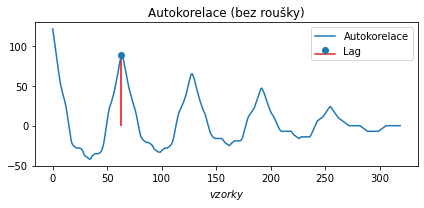

In [12]:
plt.figure(figsize=(6,3))
plt.gca().set_xlabel('$vzorky$')
plt.gca().set_title('Autokorelace (bez roušky)')
plt.plot(Rlist, label='Autokorelace')
plt.stem([lag], [Rlist[lag]], linefmt='r-', basefmt=None, label='Lag')
plt.legend()
plt.tight_layout()

In [13]:
# autokorelace s rouškou
f0_2 = []
l2 = []
for frame in range(99):
    R2list = []
    N = len(frames_toneon_2[frame])
    k = 0
    for k in range(N):
        R2 = 0
        for n in range(N-k):
            R2 += frames_toneon_2[frame][n] * frames_toneon_2[frame][n+k]
        R2list.append(R2)

    # lag + frekvence
    lag = np.argmax(R2list[32:])+32
    l2.append(lag)
    f0 = toneon_fs/lag
    f0_2.append(f0)

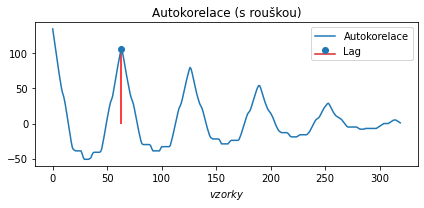

In [14]:
plt.figure(figsize=(6,3))
plt.gca().set_xlabel('$vzorky$')
plt.gca().set_title('Autokorelace (s rouškou)')
plt.plot(R2list, label='Autokorelace')
plt.stem([lag], [R2list[lag]], linefmt='r-', basefmt=None, label='Lag')
plt.legend()
plt.tight_layout()

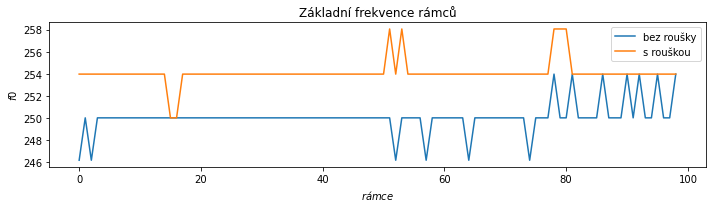

In [15]:
plt.figure(figsize=(10,3))
plt.gca().set_xlabel('$rámce$')
plt.gca().set_ylabel('$f0$')
plt.gca().set_title('Základní frekvence rámců')
plt.plot(f0_1, label="bez roušky")
plt.plot(f0_2, label="s rouškou")
plt.legend()
plt.tight_layout()

In [16]:
str1 = np.mean(f0_1)
print("Střední hodnota (bez roušky):", str1)

str2 = np.mean(f0_2)
print("Střední hodnota (s rouškou):", str2)

var1 = np.var(f0_1)
print("Rozptyl (bez roušky):", var1)

var2 = np.var(f0_2)
print("Rozptyl (s rouškou):", var2)

strlag1 = np.mean(l1)
print("Střední hodnota lagu (bez roušky):", strlag1)

strlag2 = np.mean(l2)
print("Střední hodnota lagu (s rouškou):", strlag2)

Střední hodnota (bez roušky): 250.04748338081671
Střední hodnota (s rouškou): 254.0949691487326
Rozptyl (bez roušky): 2.0077117259770008
Rozptyl (s rouškou): 1.1495078848771452
Střední hodnota lagu (bez roušky): 63.98989898989899
Střední hodnota lagu (s rouškou): 62.96969696969697


In [17]:
# DFT - numpy funkce
frames_toneoff_3 = copy.deepcopy(frames_toneoff)
DFT = []
DFT_log = []

for frame in range(99): # jednotlivé rámce
    frames_toneoff_3[frame] = np.pad(frames_toneoff_3[frame], (0, 1024 - len(frames_toneoff_3[frame])), 'constant')
    N = len(frames_toneoff_3[frame])
    G = np.fft.fft(frames_toneoff_3[frame])
    DFT.append(G)
    DFT_log.append(G)
    Gval = 10 * np.log10(np.abs(DFT[frame])**2)
    DFT_log[frame] = Gval
    DFT[frame] = DFT[frame][:512]
    DFT_log[frame] = DFT_log[frame][:512]
print(np.shape(DFT_log))

(99, 512)


In [18]:
# # DFT - vlastní implementace
# frames_toneoff_3 = copy.deepcopy(frames_toneoff)
# DFT = []
# DFT_log = []

# for frame in range(99): # jednotlivé rámce
#     frames_toneoff_3[frame] = np.pad(frames_toneoff_3[frame], (0, 1024 - len(frames_toneoff_3[frame])), 'constant')
#     N = len(frames_toneoff_3[frame])
#     k = 0
#     Xlist = []
#     for k in range(N): # pro všechna X[k] v rámci
#         X = 0 # X[k] = X
#         for n in range(N): # suma
#             M = np.exp(-2j * np.pi * k * n / N)
#             X += frames_toneoff_3[frame][n] * M
#         Xlist.append(X)
#     DFT.append(Xlist)
#     DFT_log.append(Xlist)
#     Gval = 10 * np.log10(np.abs(DFT[frame])**2)
#     DFT_log[frame] = Gval
#     DFT[frame] = DFT[frame][:512]
#     DFT_log[frame] = DFT_log[frame][:512]

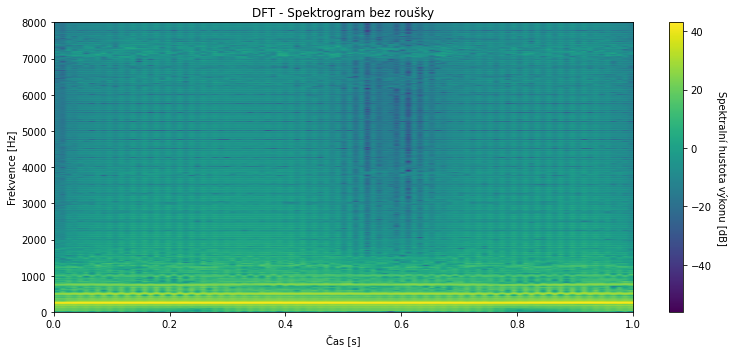

In [19]:
plt.figure(figsize=(11,5))
plt.imshow(np.rot90(DFT_log), extent=[0, 1, 0, 8000], aspect='auto')
plt.gca().set_title('DFT - Spektrogram bez roušky')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)
 
plt.tight_layout()

In [20]:
# DFT - numpy funkce
frames_toneon_3 = copy.deepcopy(frames_toneon)
DFT2 = []
DFT_log2 = []

for frame in range(99): # jednotlivé rámce
    frames_toneon_3[frame] = np.pad(frames_toneon_3[frame], (0, 1024 - len(frames_toneon_3[frame])), 'constant')
    N = len(frames_toneon_3[frame])
    G2 = np.fft.fft(frames_toneon_3[frame])
    DFT2.append(G2)
    DFT_log2.append(G2)
    Gval2 = 10 * np.log10(np.abs(DFT2[frame])**2)
    DFT_log2[frame] = Gval2
    DFT2[frame] = DFT2[frame][:512]
    DFT_log2[frame] = DFT_log2[frame][:512]
print(np.shape(DFT_log2))

(99, 512)


In [21]:
# # DFT - vlastní implementace
# frames_toneon_3 = copy.deepcopy(frames_toneon)
# DFT2 = []
# DFT_log2 = []

# for frame in range(99): # jednotlivé rámce
#     frames_toneon_3[frame] = np.pad(frames_toneon_3[frame], (0, 1024 - len(frames_toneon_3[frame])), 'constant')
#     N = len(frames_toneon_3[frame])
#     k = 0
#     Xlist = []
#     for k in range(N): # pro všechna X[k] v rámci
#         X = 0 # X[k] = X
#         for n in range(N): # suma
#             M = np.exp(-2j * np.pi * k * n / N)
#             X += frames_toneon_3[frame][n] * M
#         Xlist.append(X)
#     DFT2.append(Xlist)
#     DFT_log2.append(Xlist)
#     Gval2 = 10 * np.log10(np.abs(DFT2[frame])**2)
#     DFT_log2[frame] = Gval2
#     DFT2[frame] = DFT2[frame][:512]
#     DFT_log2[frame] = DFT_log2[frame][:512]

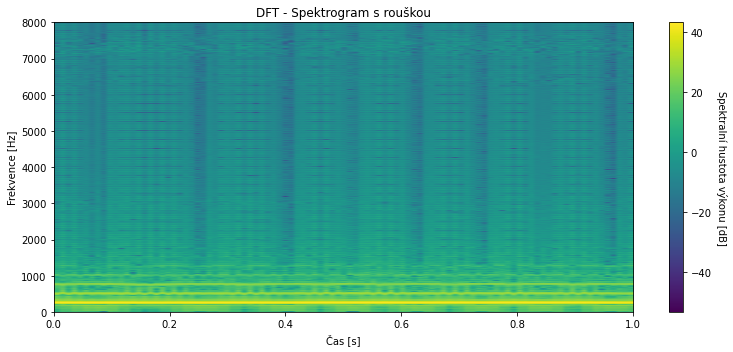

In [22]:
plt.figure(figsize=(11,5))
plt.imshow(np.rot90(DFT_log2), extent=[0, 1, 0, 8000], aspect='auto')
plt.gca().set_title('DFT - Spektrogram s rouškou')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)
 
plt.tight_layout()

In [23]:
# Frekvenční charakteristika roušky
Hlist = []
for frame in range(99):
    H = np.divide(DFT2[frame], DFT[frame])
    H = np.abs(H)
    Hlist.append(H)
    
char = np.mean(Hlist, axis=0)


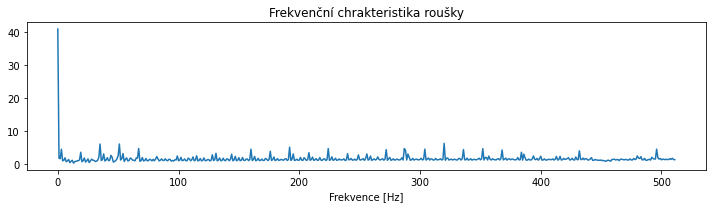

In [24]:
plt.figure(figsize=(10,3))
plt.gca().set_xlabel('Frekvence [Hz]')
plt.gca().set_title('Frekvenční chrakteristika roušky')
plt.plot(char)
plt.tight_layout()

In [25]:
# IDFT
IDFT = []
char = np.pad(char, (0, 1024 - len(char)), 'constant')
N = len(char)
for k in range(N): # pro všechna x
    X = 0 # X[k] = X
    for n in range(N): # suma
        M = np.exp(2j * np.pi * k * n / N)
        X += char[n] * M
    X = (1/N)*X
    IDFT.append(X)

# IDFT = np.fft.ifft(char)
IDFT = IDFT[:512]

C:\Users\terez\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


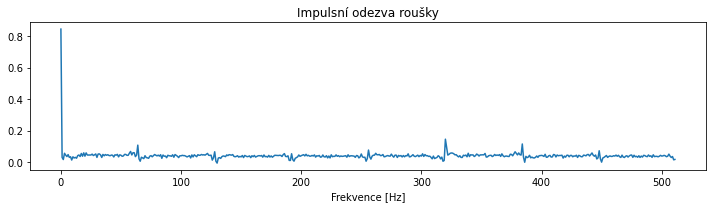

In [26]:
plt.figure(figsize=(10,3))
plt.gca().set_xlabel('Frekvence [Hz]')
plt.gca().set_title('Impulsní odezva roušky')
plt.plot(IDFT)
plt.tight_layout()

In [27]:
sim_tone = lfilter(IDFT, [1], toneoff3)
sim_sentence = lfilter(IDFT, [1], sentenceoff)

sf.write('./../audio/sim_maskon_tone.wav', np.real(sim_tone), 16000)
sf.write('./../audio/sim_maskon_sentence.wav', np.real(sim_sentence), 16000)


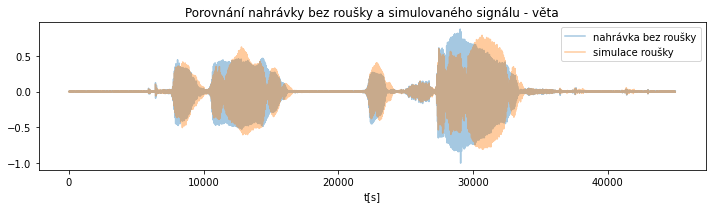

In [28]:
plt.figure(figsize=(10,3))
plt.gca().set_xlabel('t[s]')
plt.gca().set_title('Porovnání nahrávky bez roušky a simulovaného signálu - věta')
plt.plot(sentenceoff, label='nahrávka bez roušky', alpha=0.4)
plt.plot(np.real(sim_sentence), label='simulace roušky', alpha=0.4)
plt.legend()
plt.tight_layout()

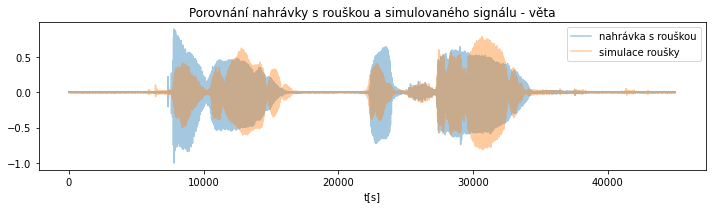

In [29]:
plt.figure(figsize=(10,3))
plt.gca().set_xlabel('t[s]')
plt.gca().set_title('Porovnání nahrávky s rouškou a simulovaného signálu - věta')
plt.plot(sentenceon, label='nahrávka s rouškou', alpha=0.4)
plt.plot(np.real(sim_sentence), label='simulace roušky', alpha=0.4)
plt.legend()
plt.tight_layout()